# Simulation for estimating ATE from imputed values

Can we capture the true ATE using estimated labels? Let's do a simulation! Let's try to keep things simple:

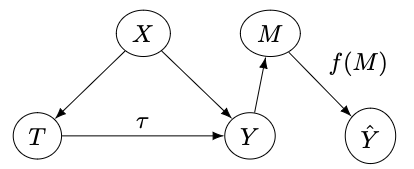

- $X$ is some confounder (e.g. urban/rural where urban areas are wealthier *and* more likely to be treated)
- $T$ is the treatment with a treatment effect $\tau$, (e.g. World Bank intervention)
- $Y$ is the outcome (change in IWI)

In our setting, we usually can't observe IWI directly. Instead, we have to rely on proxy values obtained from EO-ML.

- $M$ is the data we can observe, i.e. the satellite image. In reality, this is most likely influenced by both $X$ and $T$, but we keep it simple.
- $\hat{Y}$ is the estimate of $Y$ that we get by passing our image through the EO-ML model, $f(M)$.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import torch
from torch import nn, optim
import seaborn as sns
sns.set_theme()

I generate some samples in accordance with the DAG above with $\tau=2.0$

In [ ]:
def generate_population(n_samples=10000, tau=2.0, alpha=1.0, sigma_Y=1.0, sigma_M=0.5, seed=42):
    """
    n_samples: Number of samples
    tau: True ATE of treatment T
    alpha: Effect of confounder X on Y
    sigma_Y: Noise in Y
    sigma_M: Noise in M (proxy for Y)
    """

    # Set random seed for reproducibility
    np.random.seed(seed)

    # Generate confounder X ~ N(0, 1)
    X = np.random.normal(0, 1, n_samples)

    # Generate treatment T ~ Bernoulli(p(X)) where p(X) is a logistic function of X
    p_T_given_X = 1 / (1 + np.exp(-X))  # Logistic function
    T = np.random.binomial(1, p_T_given_X)

    # Generate outcome Y ~ N(tau * T + alpha * X, sigma_Y)
    Y = tau * T + alpha * X + np.random.normal(0, sigma_Y, n_samples)

    # Generate proxy M = Y + noise (M is a noisy version of Y)
    M = Y + np.random.normal(0, sigma_M, n_samples)

    population = pd.DataFrame({
        'X': X,
        'T': T,
        'Y': Y,
        'p_T_given_X': p_T_given_X,
        'M': M
    })

    return population

tau = 2.0
population = generate_population(tau=tau)

I fit a simple linear OLS regressor to estimate $Y$ (wealth level) from our proxy $M$ (image).

In [ ]:
M = population['M'].values.reshape(-1, 1)
Y = population['Y'].values

model = LinearRegression()
model.fit(M, Y)

test_population = generate_population(tau=tau, seed=43)
M = test_population['M'].values.reshape(-1, 1)
Y = test_population['Y'].values

pred_Y = model.predict(M)

res = Y - pred_Y
test_population['Y_hat'] = pred_Y
test_population['Residuals'] = res

From these plots, we can see that we do well in terms off MSE. However, looking at the interactions between the residuals and other variables highlights some problems for estimating the ATE.

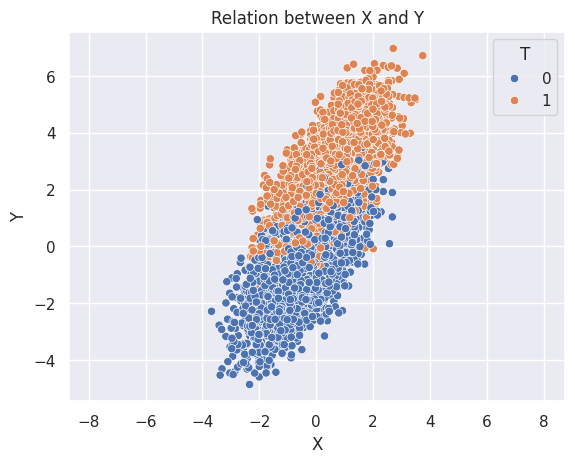

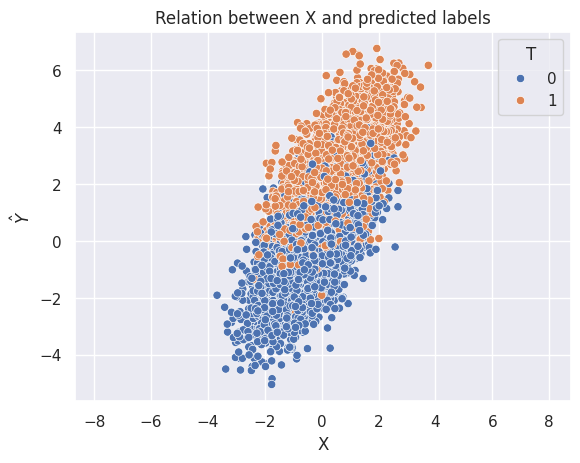

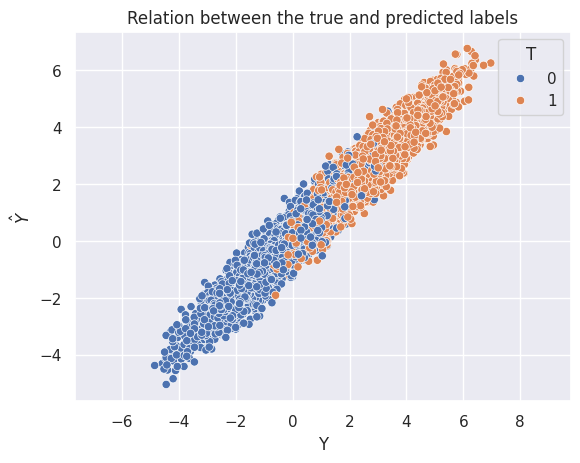

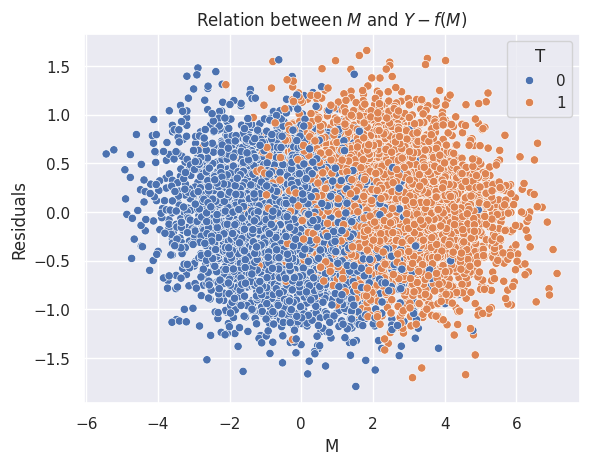

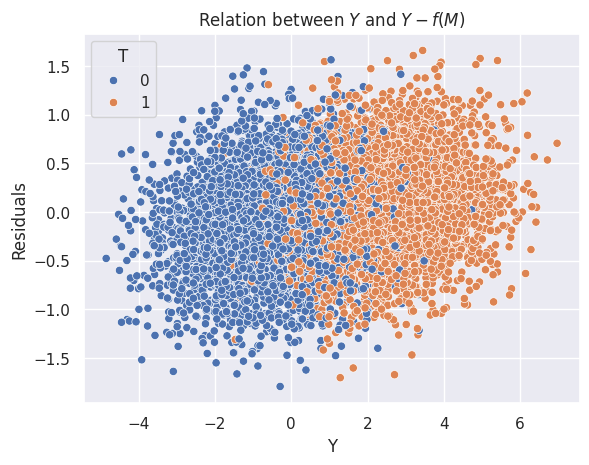

Mean Residual for Treated: -0.105, Mean Residual for Control: 0.068


In [ ]:
sns.scatterplot(data=test_population, x='X', y='Y', hue='T')
plt.title('Relation between X and Y')
plt.axis('equal')
plt.show()

sns.scatterplot(data=test_population, x='X', y='Y_hat', hue='T')
plt.title('Relation between X and predicted labels')
plt.ylabel(r'$\hat{Y}$')
plt.axis('equal')
plt.show()

sns.scatterplot(data=test_population, x='Y', y='Y_hat', hue='T')
plt.title('Relation between the true and predicted labels')
plt.ylabel(r'$\hat{Y}$')
plt.axis('equal')
plt.show()

sns.scatterplot(data=test_population, x='M', y='Residuals', hue='T')
plt.title(r'Relation between $M$ and $Y-f(M)$')
plt.show()

sns.scatterplot(data=test_population, x='Y', y='Residuals', hue='T')
plt.title(r'Relation between $Y$ and $Y-f(M)$')
plt.show()

mean_res_t = test_population.groupby('T')['Residuals'].mean()
print(f'Mean Residual for Treated: {mean_res_t[0]:.3f}, Mean Residual for Control: {mean_res_t[1]:.3f}')

Our $\hat{Y}$ ends up overestimating the value when $Y$ is low and underestimating when $Y$ is high. There's a regression-to-the-mean effect, as the overall prediction error is lowest when we smooth out the "noise". As treated samples are more likely to be high and control samples are more likely to be low, this will lead us to underestimate the ATE.

In [ ]:
# Calculate IPTW weights
weights_treated = test_population['T'].values / test_population['p_T_given_X'].values
weights_control = (1 - test_population['T'].values) / (1 - test_population['p_T_given_X'].values)

# Calculate weighted outcomes
weighted_outcome_treated = weights_treated * pred_Y
weighted_outcome_control = weights_control * pred_Y

# Estimate the average treatment effect (ATE)
ATE_estimate = np.mean(weighted_outcome_treated - weighted_outcome_control)
print(f'Estimated ATE: {ATE_estimate:.3f}, True ATE: {tau:.3f}')

Estimated ATE: 1.854, True ATE: 2.000


## Possible fix

What ends up killing the signal is that there is a correlation between the treatment and the residuals. In our setup, we are not allowed to look at the treatment while fitting our model. However, the effect of $T$ on the residuals should go entirely through $Y$, which we do observe. If we can kill this correlation, we shouldn't have this problem. We do this by adding a penalty term for correlation to the MSE-loss and fit a model with SGD:

$$
\operatorname{Loss}= (1 - \lambda) \cdot \operatorname{MSE}(Y, \hat{Y})+\lambda \cdot \operatorname{Corr}(Y, Y-\hat{Y})^2
$$

In [ ]:
M_tensor = torch.tensor(M, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32).view(-1, 1)  # Match (N, 1) shape

# Custom loss function
def custom_loss(Y_true, Y_pred, lambda_reg):
    mse_loss = nn.functional.mse_loss(Y_pred, Y_true)
    residuals = Y_true - Y_pred
    # Flatten Y_true and residuals for correlation calculation
    Y_true_flat = Y_true.view(-1)
    residuals_flat = residuals.view(-1)
    corr = torch.corrcoef(torch.stack([Y_true_flat, residuals_flat]))[0, 1]
    return (1.0 - lambda_reg) * mse_loss + lambda_reg * corr**2  # Square correlation to penalize both positive and negative correlation

decorr_model = nn.Linear(1, 1)  # Simple linear model

optimizer = optim.SGD(decorr_model.parameters(), lr=0.01)
lambda_reg = 0.9  # Tuneable Hyperparameter

for epoch in range(1000):
    optimizer.zero_grad()
    Y_pred = decorr_model(M_tensor)
    loss = custom_loss(Y_tensor, Y_pred, lambda_reg)
    loss.backward()
    optimizer.step()

with torch.no_grad():
    pred_Y_decorr = decorr_model(M_tensor)
    pred_Y_decorr = pred_Y_decorr.detach().numpy().flatten()
    population['Y_hat_decorr'] = pred_Y_decorr
    population['Decorrelated Residuals'] = Y - pred_Y_decorr

If we pick a high enough value for ```lambda_reg``` we should minimize the correlation between $Y$ and the residuals, at the expense of a lower MSE. This should result in minimizing the correlation between $T$ and the residuals.

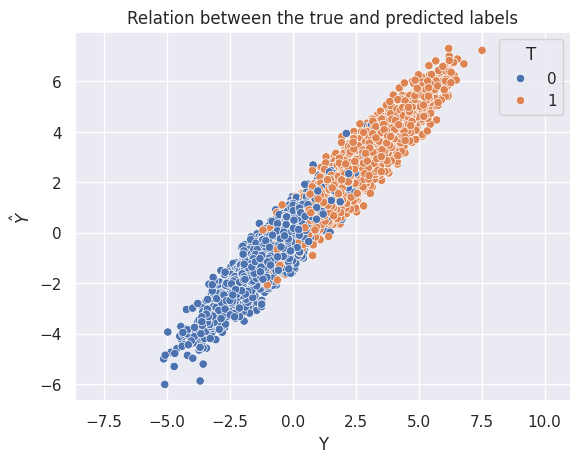

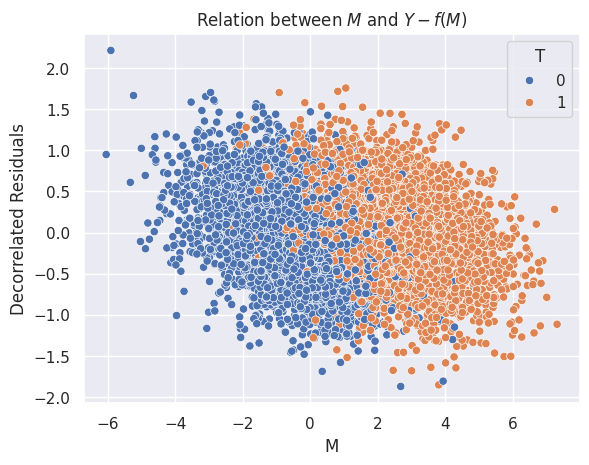

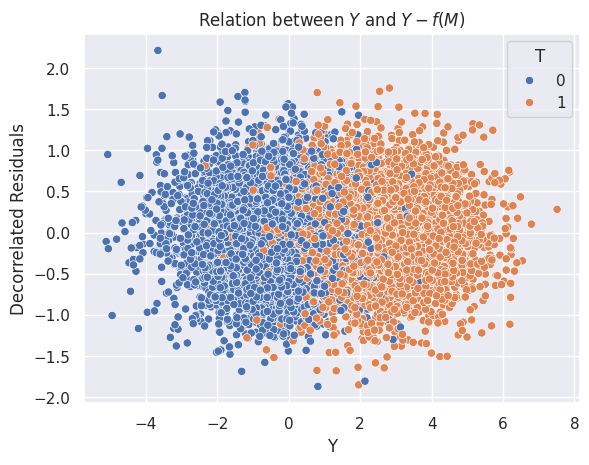

Mean Residual for Treated: -0.008, Mean Residual for Control: 0.008


In [ ]:
sns.scatterplot(data=population, x='Y', y='Y_hat_decorr', hue='T')
plt.title('Relation between the true and predicted labels')
plt.ylabel(r'$\hat{Y}$')
plt.axis('equal')
plt.show()

sns.scatterplot(data=population, x='M', y='Decorrelated Residuals', hue='T')
plt.title(r'Relation between $M$ and $Y-f(M)$')
plt.show()

sns.scatterplot(data=population, x='Y', y='Decorrelated Residuals', hue='T')
plt.title(r'Relation between $Y$ and $Y-f(M)$')
plt.show()

mean_res_t = population.groupby('T')['Decorrelated Residuals'].mean()
print(f'Mean Residual for Treated: {mean_res_t[0]:.3f}, Mean Residual for Control: {mean_res_t[1]:.3f}')

For this "decorrelated" model, the correlation between $Y$ and the resulting residuals is much smaller, same with the correlation to $T$.

In [ ]:
print(f"Correlation between Y and OG Residuals {np.corrcoef(population['Y'], population['Residuals'])[0, 1]:.3f}")
print(f"Correlation between Y and Decorrelated Residuals {np.corrcoef(population['Y'], population['Decorrelated Residuals'])[0, 1]:.3f}")
print('')
print(f"Correlation between T and OG Residuals {np.corrcoef(population['T'], population['Residuals'])[0, 1]:.3f}")
print(f"Correlation between T and Decorrelated Residuals {np.corrcoef(population['T'], population['Decorrelated Residuals'])[0, 1]:.3f}")

Correlation between Y and Residuals 0.247
Correlation between Y and Decorrelated Residuals 0.007

Correlation between T and Residuals 0.191
Correlation between T and Decorrelated Residuals 0.016


We now no longer underestimate the ATE.

In [ ]:
# Calculate weighted outcomes for the test samples
weighted_outcome_treated_decorr = weights_treated * pred_Y_decorr
weighted_outcome_control_decorr = weights_control * pred_Y_decorr

# Estimate the average treatment effect (ATE)
ATE_estimate_decorr = np.mean(weighted_outcome_treated_decorr - weighted_outcome_control_decorr)
print(f'Estimated ATE: {ATE_estimate:.3f}, Decorrelated Estimated ATE: {ATE_estimate_decorr:.3f}, True ATE: {tau:.3f}')

Estimated ATE: 1.918, Decorrelated Estimated ATE: 2.039, True ATE: 2.000


I need to bootstrap these a couple of times to get some confidence intervals